# Automated Convergence Diagnostics using the callback interface

Knowing when to stop sampling can be very useful when running expensive MCMC procedures. Ideally, if we want unbiased results, we want the sampler to stop after it has converged to the stationary phase (i.e. after the burn-in/warm-up period is over). To do this we can combine different ``Convergence Diagnostics`` offered as ``callback functions`` by zeus.

We will start by setting the simple problem of sampling from a bimodal Gaussian mixture distribution:

In [105]:
import zeus
import numpy as np
import matplotlib.pyplot as plt

nsteps, nwalkers, ndim = 100000, 50, 5

def log_prob(x):
    return np.logaddexp(-0.5 * np.sum(x ** 2), -0.5 * np.sum((x - 4.0) ** 2))

x0 = 1e-3*np.random.randn(nwalkers,ndim) + 5.0

Where ``nsteps`` would be the maximum number of steps/iterations, ``ivar`` would be the inverse variance (precision) of the normal target distribution that we are going to sample from, and ``x0`` is the starting position of the walkers.

We will then define all the convergence diagnostics that we will use as ``callback functions``.

First of all, we would like check the integrated autocorrelation time (IAT) of the chain every ``ncheck=100`` steps and make sure that we don't stop running unless the length of the chain is longer than ``nact=50`` times the IAT and that the rate of change of IAT drops bellow 1 percent (i.e. ``dact=0.01``). We would also discard the first half of the chain (i.e. ``discard=0.5``) before computing the IAT.

In [106]:
cb0 = zeus.callbacks.AutocorrelationCallback(ncheck=100, dact=0.01, nact=50, discard=0.5)

We will then use the **Split-R Gelman-Rubin statistic** computed using different segments (i.e. split into ``nsplits=2`` parts) of the same chain and decide that the sampler has converged if its value drops bellow ``(1+epsilon)=1.01``.

In [107]:
cb1 = zeus.callbacks.SplitRCallback(ncheck=100, epsilon=0.01, nsplits=2, discard=0.5)

Finally, just to make sure that the sampler doesn't stop too early, we will set the minimum number of iterations to ``nmin=500``.

In [108]:
cb2 = zeus.callbacks.MinIterCallback(nmin=500)

We are now ready to start sampling and require that all three of the aforementioned criteria are satisfied before sampling terminates.

In [109]:
sampler = zeus.EnsembleSampler(nwalkers, ndim, log_prob)
sampler.run_mcmc(x0, nsteps, callbacks=[cb0, cb1, cb2])

Initialising ensemble of 50 walkers...
Sampling progress :   2%|▏         | 1898/100000 [00:13<13:42, 119.22it/s]

We noticed that the sampler automatically stopped running after approximately ``1900`` iterations. We can now have a look at the ``split-R`` statistics and the IAT estimate.

Sampling progress :   2%|▏         | 1900/100000 [00:13<11:50, 138.00it/s]


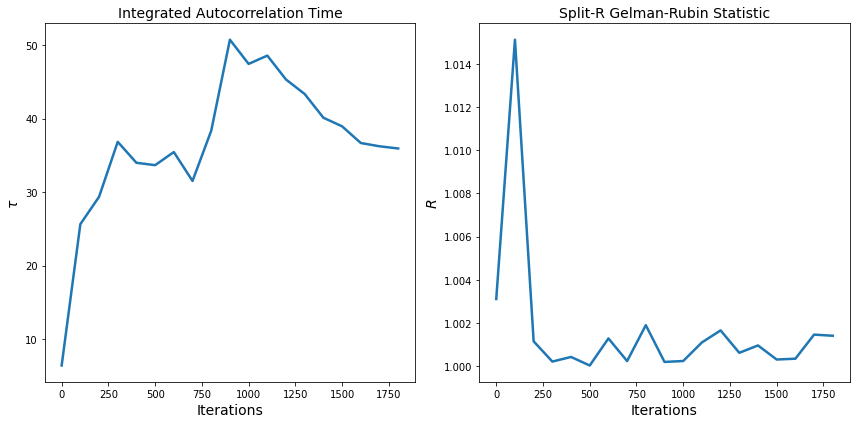

In [110]:
tau = cb0.estimates
R = cb1.estimates

N = np.arange(len(tau)) * 100


plt.figure(figsize=(12,6))
plt.subplot(121)

plt.plot(N, tau, lw=2.5)
plt.title('Integrated Autocorrelation Time', fontsize=14)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel(r'$\tau$', fontsize=14)


plt.subplot(122)

plt.plot(N, R, lw=2.5)
plt.title('Split-R Gelman-Rubin Statistic', fontsize=14)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel(r'$R$', fontsize=14)

plt.tight_layout()
plt.show()

We can also have a look at the traces of the walkers.

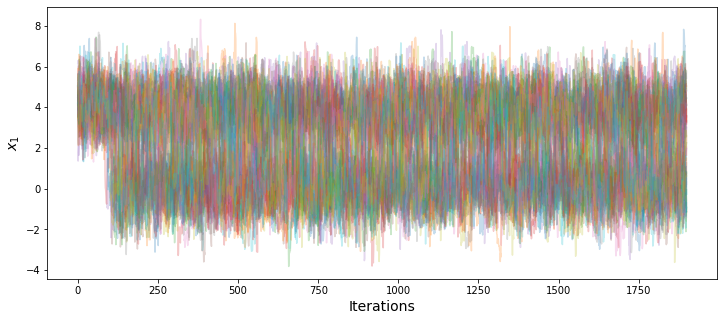

In [111]:
samples = sampler.get_chain()

plt.figure(figsize=(12,5))
plt.plot(samples[:,:,0],alpha=0.25)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel(r'$x_{1}$', fontsize=14)
plt.show()

And also the 1-dimensional marginal distribution of the first parameter.

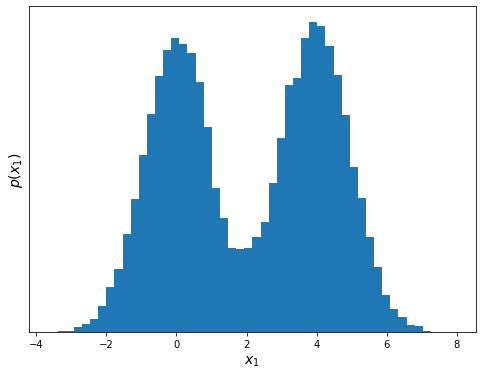

In [112]:
chain = sampler.get_chain(flat=True, discard=0.5)

plt.figure(figsize=(8,6))
plt.hist(chain[:,0], 50)
plt.gca().set_yticks([])
plt.xlabel(r"$x_{1}$", fontsize=14)
plt.ylabel(r"$p(x_{1})$", fontsize=14)
plt.show()